## Overview
Quickly demonstrates the NFourSID package.
Familiarity with subspace-identification, Kalman filtering and state-space models are assumed.

In this notebook, the following steps will be illustrated:
* Define a state-space model,
* Create a training-set and simulate measurement noise,
* Perform subspace identification and determine the order of the system which will be identified,
* Obtain a fitted state-space model,
* Use a Kalman filter to obtain predictions.

First, let's define the parameters of the state-space model and do some housekeeping.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from nfoursid.kalman import Kalman
from nfoursid.nfoursid import NFourSID
from nfoursid.state_space import StateSpace

pd.set_option('display.max_columns', None)
np.random.seed(0)  # reproducable results

NUM_TRAINING_DATAPOINTS = 1000  # create a training-set by simulating a state-space model with this many datapoints
NUM_TEST_DATAPOINTS = 20  # same for the test-set
INPUT_DIM = 3
OUTPUT_DIM = 2
INTERNAL_STATE_DIM = 4  # actual order of the state-space model in the training- and test-set
NOISE_AMPLITUDE = .1  # add noise to the training- and test-set
FIGSIZE = 8

# define system matrices for the state-space model of the training- and test-set
A = np.array([
    [1,  .01,    0,   0],
    [0,    1,  .01,   0],
    [0,    0,    1, .02],
    [0, -.01,    0,   1],
]) / 1.01
B = np.array([
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1],
    [0, 1, 1],
]
) / 3
C = np.array([
    [1, 0, 1,  1],
    [0, 0, 1, -1],
])
D = np.array([
    [1, 0, 1],
    [0, 1, 0]
]) / 10

In [6]:
PV = np.loadtxt('PV')
SP = np.loadtxt('SP')
print(PV)

[0.93182139 0.92514786 0.91824497 0.96912557 0.93982457 0.90697483
 0.93988428 0.99322184 0.98642166 0.92172619 0.92087335 0.94791791
 0.96152587 0.94939915 0.99725465 0.97889334 0.99400457 0.92539597
 0.90263996 0.99520655 0.92366268 0.99480625 0.99895413 0.98752321
 0.92428938 0.91552681 0.98425653 0.96147289 0.99679378 1.15890066
 1.20815704 1.27971552 1.34588031 1.37020434 1.4971069  1.51640253
 1.48377553 1.55027668 1.58606069 1.58179726 1.64256507 1.76594336
 1.78275164 1.76054197 1.7330789  1.69147817 1.86137463 1.71434243
 1.72006913 1.82386312 1.7722191  1.88680479 1.91564943 1.8224765
 1.91698619 1.81913679 1.83220575 1.93953719 1.87445498 1.92814157
 1.83104934 1.82031486 1.78000775 1.92796358 1.92707009 1.91057988
 1.86365508 1.97464903 1.92791058 1.84547598 1.89331241 1.98431491
 1.85359334 1.8542626  1.94429568 1.83406874 1.87904606 1.94887763
 1.9079805  1.97779394 1.88513104 1.99497049 1.81604923 1.80972583
 1.9139113  1.82489926 1.99377503 1.81297438 1.86535768 1.89861

In [8]:
state_space = StateSpace(A, B, C, D)
for i in range(len(PV)):
    state_space.step(SP,PV)

ValueError: Dimensions of `u` (149,) are inconsistent. Expected (3, 1).

Create a training-set by adding noise to a state-space model:

In [2]:
state_space = StateSpace(A, B, C, D)
for _ in range(NUM_TRAINING_DATAPOINTS):
    input_state = np.random.standard_normal((INPUT_DIM, 1))
    noise = np.random.standard_normal((OUTPUT_DIM, 1)) * NOISE_AMPLITUDE

    state_space.step(input_state, noise)

The state-space model has 3 inputs, a 4-dimensional internal state vector and 2 outputs. 
Plotting the dataset can be done using `StateSpace.plot_input_output`.

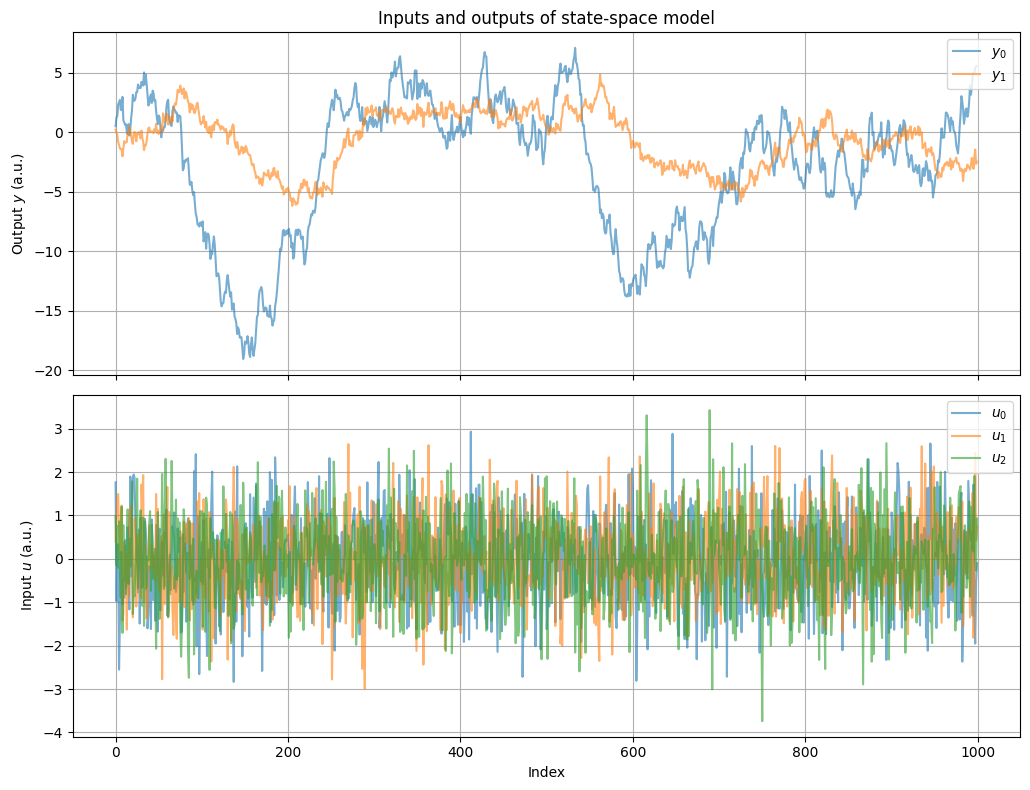

In [3]:
figsize = (1.3 * FIGSIZE, FIGSIZE)
fig = plt.figure(figsize=figsize)
state_space.plot_input_output(fig)  # the state-space model can plot its inputs and outputs
fig.tight_layout()

At the moment, suppose that we don't know the order of the internal state vector.
Let's perform subspace identification.

In [4]:
nfoursid = NFourSID(
    state_space.to_dataframe(),  # the state-space model can summarize inputs and outputs as a dataframe
    output_columns=state_space.y_column_names,
    input_columns=state_space.u_column_names,
    num_block_rows=10
)
nfoursid.subspace_identification()

Plotting the eigenvalues of the estimated observability matrix is done with `NFourSID.plot_eigenvalues`.

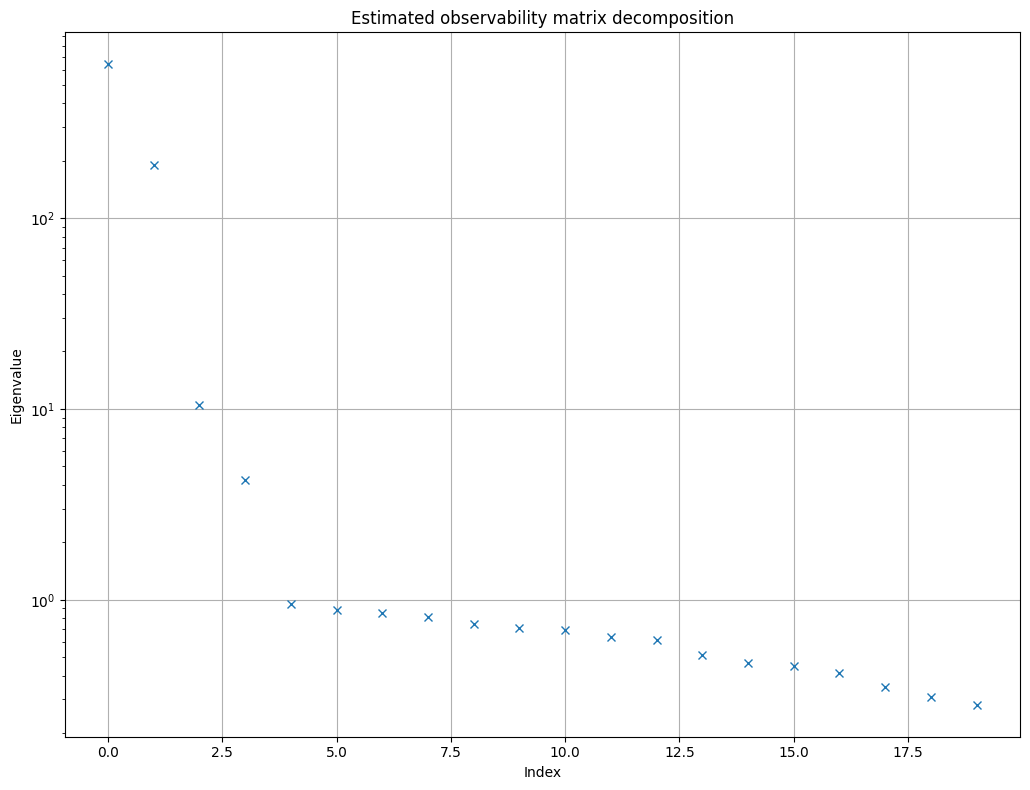

In [5]:
fig, ax = plt.subplots(figsize=figsize)
nfoursid.plot_eigenvalues(ax)
fig.tight_layout()

This gives us a signal that the order of the state-space model is 4.
Let's identify the system matrices.

In [6]:
ORDER_OF_MODEL_TO_FIT = 4
state_space_identified, covariance_matrix = nfoursid.system_identification(
    rank=ORDER_OF_MODEL_TO_FIT
)

Generate a test-set and use Kalman filtering to evaluate prediction performance:

In [7]:
kalman = Kalman(state_space_identified, covariance_matrix)
state_space = StateSpace(A, B, C, D)  # new data for the test-set
for _ in range(NUM_TEST_DATAPOINTS):  # make a test-set
    input_state = np.random.standard_normal((INPUT_DIM, 1))
    noise = np.random.standard_normal((OUTPUT_DIM, 1)) * NOISE_AMPLITUDE

    y = state_space.step(input_state, noise)  # generate test-set
    kalman.step(y, input_state)  # the Kalman filter sees the output and input, but not the actual internal state

Plot the filtered state of the Kalman filter using `Kalman.plot_filtered`.
The top graph shows the output of the Kalman filter against the filtered states.
Expected standard deviation is plotted as error bars.

The bottom graph zooms in on the filtering error.
In this plot, expected standard deviation is plotted as dotted lines.

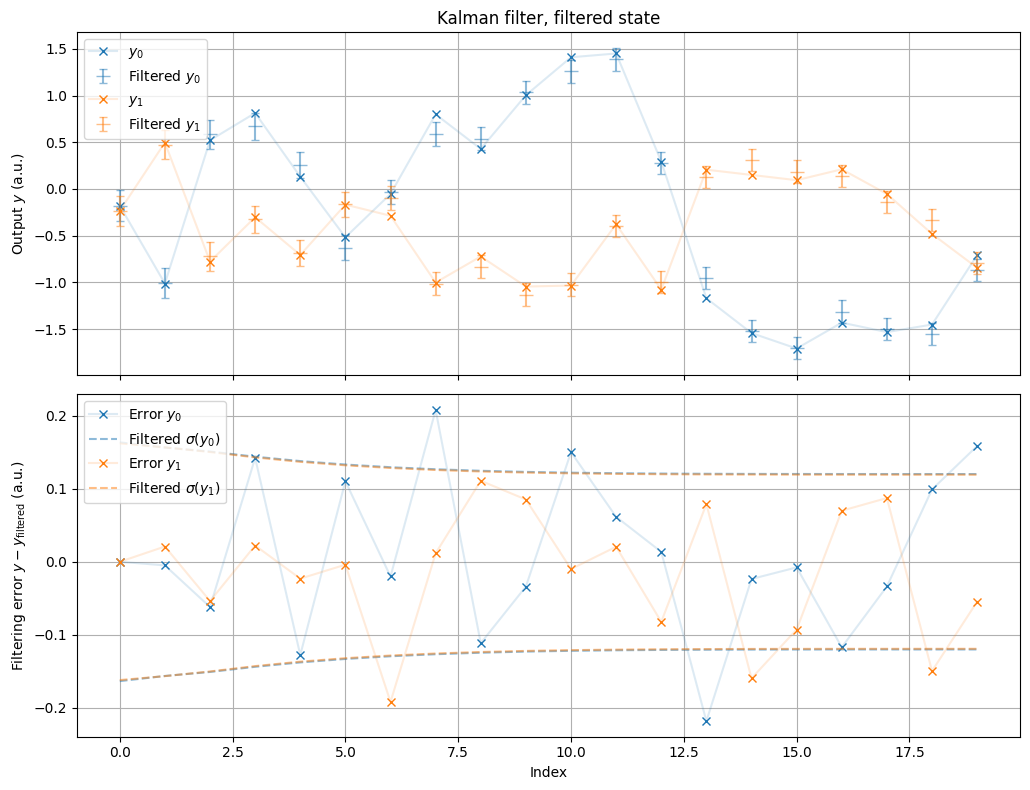

In [8]:
fig = plt.figure(figsize=figsize)
kalman.plot_filtered(fig)
fig.tight_layout()

The Kalman filter also provides an prediction of the next internal state.
Based on the predicted internal state and the fitted model, it is possible to estimate the output of the next timestep.
It is necessary to correct the output prediction with the known input of the next timestep using the estimated system matrix `Kalman.state_space.d`.
This is not a limitation, because the inputs and estimated system matrices are known to the experimenter.

The predicted outputs can be plotted using `Kalman.plot_predicted`, like the previous plot of the filtered states.
The one-step ahead predicted output, assuming no further inputs, is shown as a star with expected standard deviation as error bars.

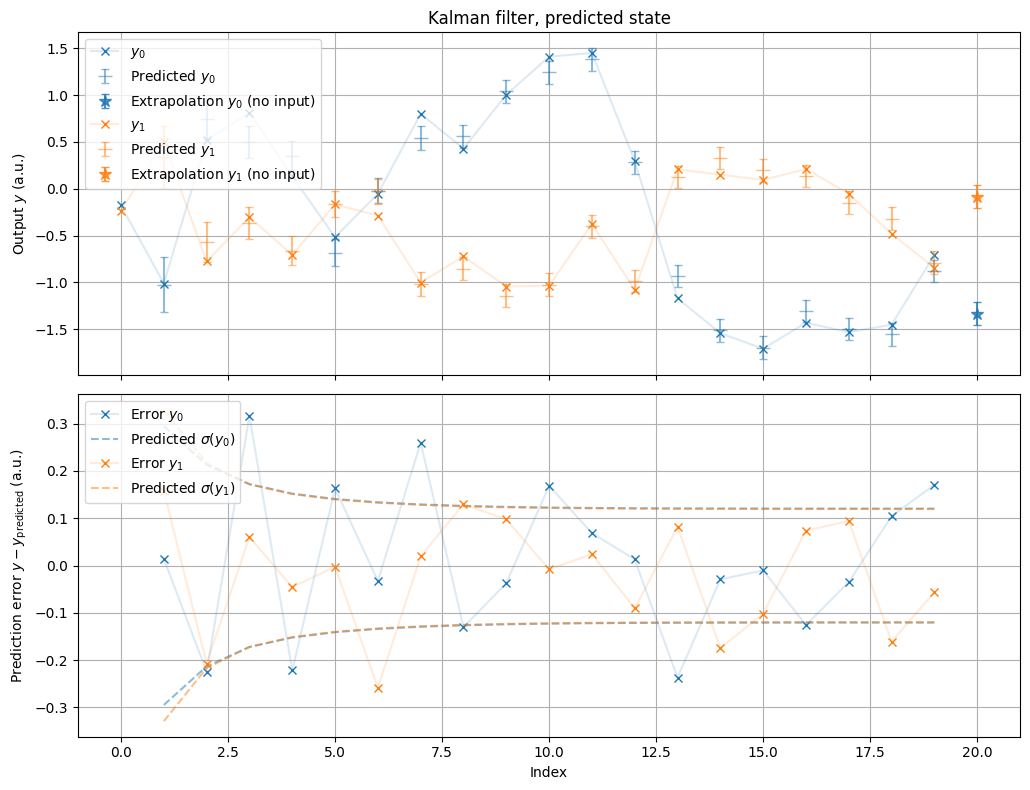

In [9]:
fig = plt.figure(figsize=figsize)
kalman.plot_predicted(fig)
fig.tight_layout()

We can access the output data of the Kalman filter using `Kalman.to_dataframe()`.
This returns a dataframe for all output columns containing
* The actual output, which was given to the Kalman filter using `Kalman.step`,
* The filtered output state,
* The next predicted state, assuming no further inputs,
* The next predicted state, adjusted ex-post with the next input.

In [10]:
kalman.to_dataframe()

$y_0$                                                         \
      actual  filtered                    next predicted (no input)   
      output    output standard deviation                    output   
0  -0.178945 -0.178940           0.163462                 -1.216790   
1  -1.011690 -1.006693           0.156388                  0.611477   
2   0.520904  0.582883           0.150897                  0.634508   
3   0.812598  0.670394           0.143842                  0.367806   
4   0.131519  0.259228           0.137846                 -0.868412   
5  -0.517449 -0.627665           0.133104                  0.086522   
6  -0.053167 -0.032980           0.129434                  0.512773   
7   0.798916  0.591154           0.126639                  0.584490   
8   0.428488  0.539967           0.124550                  0.898774   
9   1.003207  1.037168           0.123027                  1.030881   
10  1.409100  1.259052           0.121953                  1.775888   
11  1.449779  1.388264           0.121222                  0.255999   
12  0.293254  0.279755           0.120746                 -0.772931   
13 -1.169319 -0.951036           0.120450                 -1.521715   
14 -1.541937 -1.518311           0.120277                 -1.707448   
15 -1.707321 -1.699594           0.120180                 -1.269433   
16 -1.430401 -1.313311           0.120131                 -1.344939   
17 -1.531490 -1.497655           0.120107                 -1.704550   
18 -1.450757 -1.549770           0.120097                 -0.849683   
19 -0.707673 -0.866138           0.120093                 -1.332263   

                                                                           \
                      next predicted (input corrected)                      
   standard deviation                           output standard deviation   
0            0.294686                        -1.026086           0.294686   
1            0.213172                         0.745210           0.213172   
2            0.172138                         0.496306           0.172138   
3            0.152106                         0.353258           0.152106   
4            0.140827                        -0.680649           0.140827   
5            0.133847                        -0.020756           0.133847   
6            0.129284                         0.539107           0.129284   
7            0.126221                         0.558550           0.126221   
8            0.124151                         1.040365           0.124151   
9            0.122764                         1.240320           0.122764   
10           0.121853                         1.381071           0.121853   
11           0.121273                         0.280161           0.121273   
12           0.120918                        -0.932432           0.120918   
13           0.120711                        -1.512924           0.120711   
14           0.120597                        -1.697032           0.120597   
15           0.120538                        -1.304661           0.120538   
16           0.120510                        -1.496521           0.120510   
17           0.120498                        -1.555202           0.120498   
18           0.120493                        -0.878534           0.120493   
19           0.120491                              NaN           0.120491   

       $y_1$                                                         \
      actual  filtered                    next predicted (no input)   
      output    output standard deviation                    output   
0  -0.233697 -0.233619           0.162045                  0.095081   
1   0.496638  0.475776           0.156611                 -0.502705   
2  -0.776304 -0.722512           0.150240                 -0.430735   
3  -0.302252 -0.324489           0.142888                 -0.547100   
4  -0.706159 -0.683050           0.136813                 -0.176261   
5  -0.167407 -0.163382           

SIMPLE SISO SYSTEM IDENTIFICATION METHODS

METHOD 1: ARX Model (Simple and Reliable)
----------------------------------------
ARX Model Parameters:
  A (denominator): [ 1.         -0.41669376 -0.37659213]
  B (numerator): [0.18653668 0.00838642]
  Delay: 1 samples
  Poles: [ 0.85642138 -0.43972762]
  Zeros: [-0.04495856]

METHOD 2: FOPDT Model (Classic Process Control)
----------------------------------------
FOPDT Model Parameters:
  Gain (K): 0.964
  Time Constant (Tau): 10.0 samples
  Dead Time (Td): 0.0 samples

METHOD 3: Direct State-Space Identification
----------------------------------------
State-Space Matrices:
  A:
[[0.         1.        ]
 [0.37715746 0.41802682]]
  B:
[[0.        ]
 [0.19317448]]
  C:
[[1. 0.]]
  D:
[[0]]

MODEL COMPARISON
ARX          -> RMSE: 0.1568, R²: 0.8285
FOPDT        -> RMSE: 0.1895, R²: 0.7494
State-Space  -> RMSE: 0.1747, R²: 0.7869

Best method: ARX


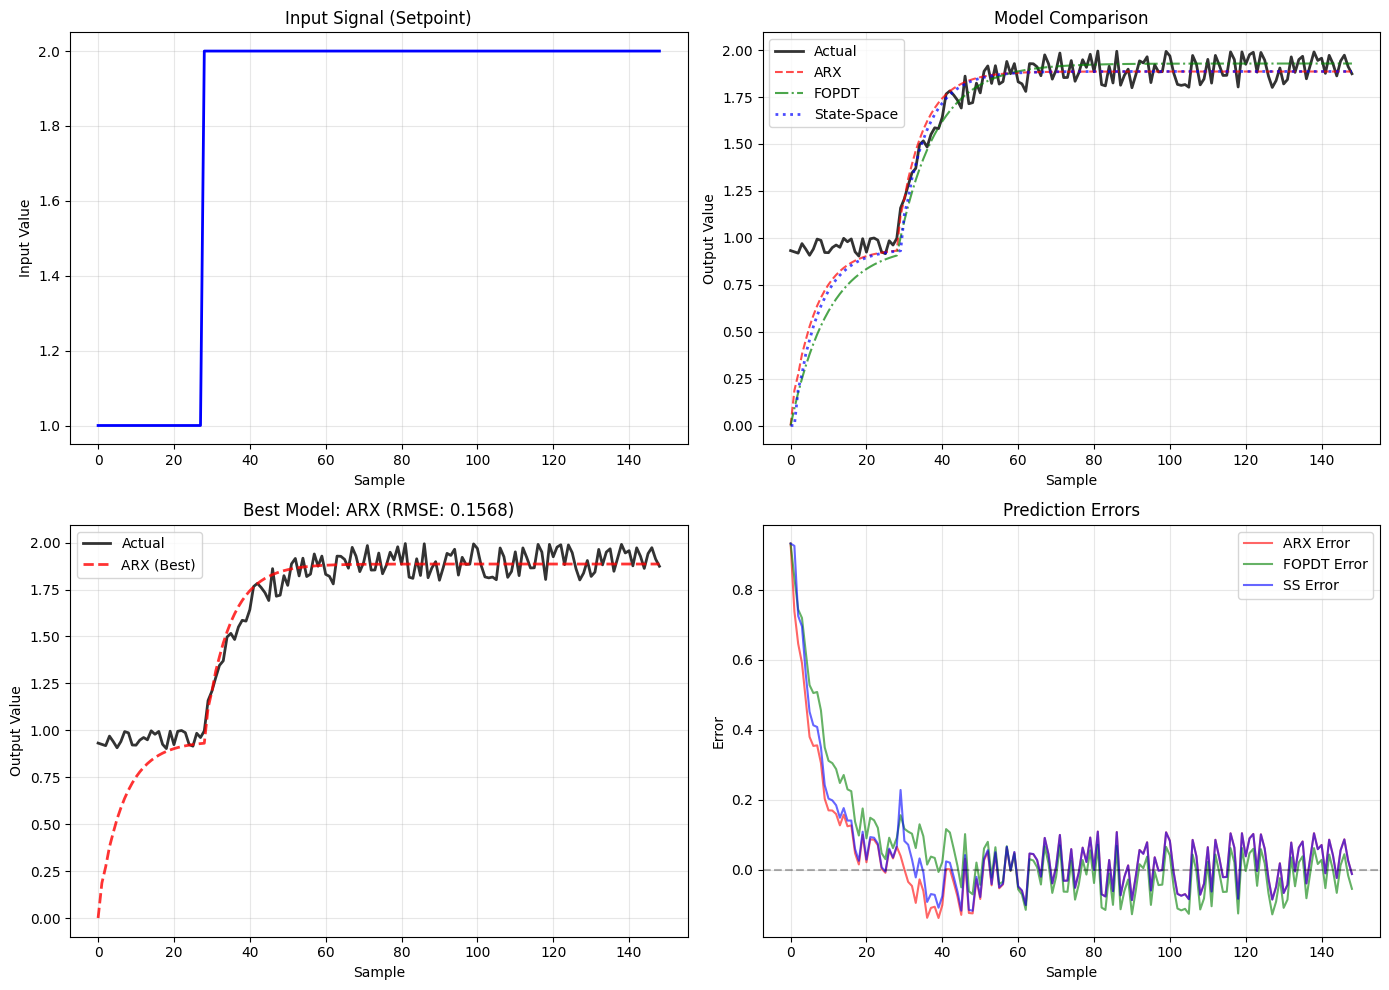


RECOMMENDATIONS
1. ARX: Best for general dynamic systems with fast sampling
2. FOPDT: Best for process control with slow dynamics
3. State-Space: Best when you need a state-space representation

For your SISO system, ARX or FOPDT will likely work best.
These methods are simple, reliable, and don't require complex libraries!


In [23]:
"""
Simple and reliable approaches for SISO system identification
No complex libraries needed - just numpy and scipy
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, optimize
from sklearn.linear_model import LinearRegression

# Assuming SP (setpoint/input) and PV (process variable/output) are already loaded
# Convert to 1D arrays if needed
u = SP.flatten() if SP.ndim > 1 else SP  # Input
y = PV.flatten() if PV.ndim > 1 else PV  # Output

print("="*60)
print("SIMPLE SISO SYSTEM IDENTIFICATION METHODS")
print("="*60)

# ===========================================================================
# METHOD 1: ARX Model (AutoRegressive with eXogenous input)
# ===========================================================================
print("\nMETHOD 1: ARX Model (Simple and Reliable)")
print("-" * 40)

def identify_arx(u, y, na=2, nb=2, nk=1):
    """
    Identify ARX model: y(t) + a1*y(t-1) + ... = b0*u(t-nk) + b1*u(t-nk-1) + ...
    
    Parameters:
    - u: input signal
    - y: output signal  
    - na: number of output terms (order of A polynomial)
    - nb: number of input terms (order of B polynomial)
    - nk: input delay (deadtime in samples)
    """
    n = len(y)
    
    # Build regression matrix
    phi = []
    y_vec = []
    
    start_idx = max(na, nb + nk - 1)
    
    for t in range(start_idx, n):
        row = []
        # Past outputs (y terms)
        for i in range(1, na + 1):
            row.append(-y[t - i])
        # Past inputs (u terms)  
        for i in range(nk, nb + nk):
            row.append(u[t - i])
        phi.append(row)
        y_vec.append(y[t])
    
    phi = np.array(phi)
    y_vec = np.array(y_vec)
    
    # Least squares solution
    theta = np.linalg.lstsq(phi, y_vec, rcond=None)[0]
    
    # Extract parameters
    a_params = np.concatenate([[1], theta[:na]])  # [1, a1, a2, ...]
    b_params = theta[na:]  # [b0, b1, ...]
    
    return a_params, b_params, nk

# Identify ARX model
a_arx, b_arx, delay = identify_arx(u, y, na=2, nb=2, nk=1)

print(f"ARX Model Parameters:")
print(f"  A (denominator): {a_arx}")
print(f"  B (numerator): {b_arx}")
print(f"  Delay: {delay} samples")

# Convert to transfer function
sys_tf = signal.TransferFunction(b_arx, a_arx, dt=True)
print(f"  Poles: {sys_tf.poles}")
print(f"  Zeros: {sys_tf.zeros}")

# Simulate ARX model
y_arx = signal.dlsim(sys_tf, u)[1].flatten()

# ===========================================================================
# METHOD 2: First-Order Plus Dead Time (FOPDT) Model
# ===========================================================================
print("\nMETHOD 2: FOPDT Model (Classic Process Control)")
print("-" * 40)

def identify_fopdt(u, y, sample_time=1.0):
    """
    Identify First-Order Plus Dead Time model from step response
    Transfer function: K * exp(-Td*s) / (Tau*s + 1)
    """
    # Find the step change
    step_idx = np.where(np.diff(u) != 0)[0]
    if len(step_idx) > 0:
        step_idx = step_idx[0] + 1
    else:
        step_idx = 0
        
    # Get steady-state values
    u_initial = np.mean(u[:max(1, step_idx-5)])
    u_final = np.mean(u[min(len(u)-1, step_idx+50):])
    y_initial = np.mean(y[:max(1, step_idx-5)])
    y_final = np.mean(y[-30:])  # Last 30 points
    
    # Calculate gain
    K = (y_final - y_initial) / (u_final - u_initial) if (u_final - u_initial) != 0 else 1.0
    
    # Find time delay (dead time)
    # Look for when output starts responding
    threshold = y_initial + 0.02 * (y_final - y_initial)
    dead_time_idx = step_idx
    for i in range(step_idx, min(step_idx + 50, len(y))):
        if abs(y[i] - y_initial) > abs(threshold - y_initial):
            dead_time_idx = i
            break
    Td = (dead_time_idx - step_idx) * sample_time
    
    # Find time constant (63.2% of change)
    target_63 = y_initial + 0.632 * (y_final - y_initial)
    tau_idx = dead_time_idx
    for i in range(dead_time_idx, len(y)):
        if (y_final > y_initial and y[i] >= target_63) or \
           (y_final < y_initial and y[i] <= target_63):
            tau_idx = i
            break
    Tau = (tau_idx - dead_time_idx) * sample_time
    
    if Tau <= 0:
        Tau = 10 * sample_time  # Default if not found
    
    return K, Tau, Td

K, Tau, Td = identify_fopdt(u, y)

print(f"FOPDT Model Parameters:")
print(f"  Gain (K): {K:.3f}")
print(f"  Time Constant (Tau): {Tau:.1f} samples")  
print(f"  Dead Time (Td): {Td:.1f} samples")

# Create discrete-time FOPDT model
# Discretize: G(z) = K * (1-a) / (z-a) with delay
a_fopdt = np.exp(-1/Tau)
num_fopdt = [K * (1 - a_fopdt)]
den_fopdt = [1, -a_fopdt]

# Add delay by padding numerator with zeros
delay_samples = int(Td)
if delay_samples > 0:
    num_fopdt = [0] * delay_samples + num_fopdt

sys_fopdt = signal.TransferFunction(num_fopdt, den_fopdt, dt=True)
y_fopdt = signal.dlsim(sys_fopdt, u)[1].flatten()

# ===========================================================================
# METHOD 3: Direct State-Space via Least Squares
# ===========================================================================
print("\nMETHOD 3: Direct State-Space Identification")
print("-" * 40)

def identify_ss_direct(u, y, order=2):
    """
    Direct state-space identification using least squares
    Much simpler than N4SID for SISO systems
    """
    n = len(y)
    
    # Build Hankel matrices
    # For SISO, this is much simpler than full N4SID
    Y = []
    U = []
    
    for i in range(order, n-1):
        # Stack past outputs as state
        Y.append(y[i+1])
        state = list(y[i-order+1:i+1])  # Past outputs as state proxy
        state.append(u[i])  # Current input
        U.append(state)
    
    Y = np.array(Y)
    U = np.array(U)
    
    # Solve Y = U * theta using least squares
    theta = np.linalg.lstsq(U, Y, rcond=None)[0]
    
    # Construct state-space matrices (observable canonical form)
    A = np.zeros((order, order))
    A[:-1, 1:] = np.eye(order-1)  # Shift matrix
    A[-1, :] = theta[:order]  # Last row from identification
    
    B = np.zeros((order, 1))
    B[-1, 0] = theta[order]  # Input coefficient
    
    C = np.zeros((1, order))
    C[0, 0] = 1  # Output first state
    
    D = np.array([[0]])
    
    return A, B, C, D

A_ss, B_ss, C_ss, D_ss = identify_ss_direct(u, y, order=2)

print(f"State-Space Matrices:")
print(f"  A:\n{A_ss}")
print(f"  B:\n{B_ss}")
print(f"  C:\n{C_ss}")
print(f"  D:\n{D_ss}")

# Simulate state-space model
sys_ss = signal.StateSpace(A_ss, B_ss, C_ss, D_ss, dt=True)
y_ss = signal.dlsim(sys_ss, u)[1].flatten()

# ===========================================================================
# COMPARISON PLOT
# ===========================================================================
print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)

# Calculate metrics for each method
methods = ['ARX', 'FOPDT', 'State-Space']
predictions = [y_arx, y_fopdt, y_ss]
metrics = []

for name, pred in zip(methods, predictions):
    mse = np.mean((y - pred)**2)
    rmse = np.sqrt(mse)
    # R-squared
    ss_res = np.sum((y - pred)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
    
    metrics.append({
        'Method': name,
        'RMSE': rmse,
        'R²': r2
    })
    print(f"{name:12s} -> RMSE: {rmse:.4f}, R²: {r2:.4f}")

# Find best method
best_idx = np.argmin([m['RMSE'] for m in metrics])
print(f"\nBest method: {methods[best_idx]}")

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Input Signal
axes[0, 0].plot(u, 'b-', linewidth=2)
axes[0, 0].set_title('Input Signal (Setpoint)')
axes[0, 0].set_xlabel('Sample')
axes[0, 0].set_ylabel('Input Value')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: All Models Comparison
axes[0, 1].plot(y, 'k-', linewidth=2, label='Actual', alpha=0.8)
axes[0, 1].plot(y_arx, 'r--', label='ARX', alpha=0.7)
axes[0, 1].plot(y_fopdt, 'g-.', label='FOPDT', alpha=0.7)
axes[0, 1].plot(y_ss, 'b:', label='State-Space', alpha=0.7, linewidth=2)
axes[0, 1].set_title('Model Comparison')
axes[0, 1].set_xlabel('Sample')
axes[0, 1].set_ylabel('Output Value')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Best Model Detail
best_pred = predictions[best_idx]
axes[1, 0].plot(y, 'k-', linewidth=2, label='Actual', alpha=0.8)
axes[1, 0].plot(best_pred, 'r--', linewidth=2, label=f'{methods[best_idx]} (Best)', alpha=0.8)
axes[1, 0].set_title(f'Best Model: {methods[best_idx]} (RMSE: {metrics[best_idx]["RMSE"]:.4f})')
axes[1, 0].set_xlabel('Sample')
axes[1, 0].set_ylabel('Output Value')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Error Analysis
errors = [y - pred for pred in predictions]
axes[1, 1].plot(errors[0], 'r-', label='ARX Error', alpha=0.6)
axes[1, 1].plot(errors[1], 'g-', label='FOPDT Error', alpha=0.6)
axes[1, 1].plot(errors[2], 'b-', label='SS Error', alpha=0.6)
axes[1, 1].axhline(y=0, color='k', linestyle='--', alpha=0.3)
axes[1, 1].set_title('Prediction Errors')
axes[1, 1].set_xlabel('Sample')
axes[1, 1].set_ylabel('Error')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("RECOMMENDATIONS")
print("="*60)
print("1. ARX: Best for general dynamic systems with fast sampling")
print("2. FOPDT: Best for process control with slow dynamics")  
print("3. State-Space: Best when you need a state-space representation")
print("\nFor your SISO system, ARX or FOPDT will likely work best.")
print("These methods are simple, reliable, and don't require complex libraries!")

In [15]:
# Add this diagnostic code right after creating the nfoursid object
import inspect
print("subspace_identification method signature:")
try:
    sig = inspect.signature(nfoursid.subspace_identification)
    print(sig)
except:
    print("Could not get signature")

# Also check what attributes/methods are available
print("\nNFourSID object methods:")
methods = [method for method in dir(nfoursid) if not method.startswith('_')]
print(methods)

subspace_identification method signature:
()

NFourSID object methods:
['R22', 'R32', 'R32_decomposition', 'num_block_rows', 'plot_eigenvalues', 'subspace_identification', 'system_identification', 'u_array', 'u_columns', 'u_dim', 'x_dim', 'y_array', 'y_columns', 'y_dim']


In [37]:
"""
SIPPY Implementation for Subspace System Identification
Using sippy_unipi package
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import sippy_unipi

# Convert data to 1D arrays
u = SP.flatten() if SP.ndim > 1 else SP  # Input
y = PV.flatten() if PV.ndim > 1 else PV  # Output

print("="*60)
print("SIPPY SUBSPACE IDENTIFICATION")
print("="*60)
print(f"Data length: {len(y)} samples")

# Try different model orders to find the best
best_r2 = -np.inf
best_order = None
best_sys = None
results = []

print("\nTrying different model orders...")
print("-" * 40)

for order in range(1, 5):  # Try orders 1 through 4
    try:
        # N4SID identification
        # The function returns (sys, info) tuple, so we need to unpack it
        sys_id, info = sippy_unipi.system_identification(
            y, u, 
            id_method='N4SID',        # Can also try 'MOESP' or 'CVA'
            SS_fixed_order=order,      # State order
            SS_D_required=False,       # No direct feedthrough
            SS_A_stability=True,       # Ensure stable system
            SS_f=20,                   # Past horizon (adjust if needed)
        )
        
        # Create state space and simulate
        sys_ss = signal.StateSpace(sys_id.A, sys_id.B, sys_id.C, sys_id.D, dt=True)
        _, y_sim = signal.dlsim(sys_ss, u)
        y_sim = y_sim.flatten()
        
        # Calculate metrics
        mse = np.mean((y - y_sim)**2)
        rmse = np.sqrt(mse)
        ss_res = np.sum((y - y_sim)**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
        
        # Check stability (all eigenvalues inside unit circle)
        eigenvalues = np.linalg.eigvals(sys_id.A)
        is_stable = all(abs(eig) < 1 for eig in eigenvalues)
        
        results.append({
            'order': order,
            'sys': sys_id,
            'info': info,
            'y_sim': y_sim,
            'r2': r2,
            'rmse': rmse,
            'stable': is_stable,
            'eigenvalues': eigenvalues
        })
        
        print(f"  Order {order}: R² = {r2:.4f}, RMSE = {rmse:.4f}, Stable = {is_stable}")
        print(f"           Eigenvalues: {np.abs(eigenvalues)}")
        
        # Update best if this is better
        if r2 > best_r2 and is_stable:
            best_r2 = r2
            best_order = order
            best_sys = sys_id
            
    except Exception as e:
        print(f"  Order {order}: Failed - {e}")
        # Try alternative: maybe it returns just the system for some configs
        try:
            sys_id = sippy_unipi.system_identification(
                y, u, 
                id_method='N4SID',
                SS_fixed_order=order,
                SS_D_required=False,
                SS_A_stability=True,
            )
            
            # If this worked, it returns just the system
            sys_ss = signal.StateSpace(sys_id.A, sys_id.B, sys_id.C, sys_id.D, dt=True)
            _, y_sim = signal.dlsim(sys_ss, u)
            y_sim = y_sim.flatten()
            
            mse = np.mean((y - y_sim)**2)
            rmse = np.sqrt(mse)
            ss_res = np.sum((y - y_sim)**2)
            ss_tot = np.sum((y - np.mean(y))**2)
            r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
            
            eigenvalues = np.linalg.eigvals(sys_id.A)
            is_stable = all(abs(eig) < 1 for eig in eigenvalues)
            
            results.append({
                'order': order,
                'sys': sys_id,
                'info': None,
                'y_sim': y_sim,
                'r2': r2,
                'rmse': rmse,
                'stable': is_stable,
                'eigenvalues': eigenvalues
            })
            
            print(f"  Order {order}: R² = {r2:.4f}, RMSE = {rmse:.4f}, Stable = {is_stable}")
            print(f"           Eigenvalues: {np.abs(eigenvalues)}")
            
            if r2 > best_r2 and is_stable:
                best_r2 = r2
                best_order = order
                best_sys = sys_id
                
        except Exception as e2:
            print(f"  Order {order}: Alternative also failed - {e2}")

# Use the best system
if best_sys is not None:
    print(f"\n*** Selected Model: Order {best_order} with R² = {best_r2:.4f} ***")
    
    A = best_sys.A
    B = best_sys.B
    C = best_sys.C
    D = best_sys.D
    
    print(f"\nSystem Matrices:")
    print(f"A ({A.shape}):\n{A}")
    print(f"B ({B.shape}):\n{B}")
    print(f"C ({C.shape}):\n{C}")
    print(f"D ({D.shape}):\n{D}")
    
    # Get best simulation
    best_result = next(r for r in results if r['order'] == best_order)
    y_best = best_result['y_sim']
    
    # Calculate steady-state gain
    try:
        dc_gain = np.sum(C @ np.linalg.inv(np.eye(len(A)) - A) @ B + D)
        print(f"\nDC Gain: {dc_gain:.4f}")
    except:
        print("\nDC Gain: Could not calculate")
    
    # Plotting
    fig, axes = plt.subplots(3, 1, figsize=(12, 9))
    
    # Plot 1: Input
    axes[0].plot(u, 'b-', linewidth=2)
    axes[0].set_title('Input (Setpoint)')
    axes[0].set_ylabel('Value')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xlim([0, len(u)])
    
    # Plot 2: Output comparison
    axes[1].plot(y, 'k-', linewidth=2, label='Actual', alpha=0.8)
    axes[1].plot(y_best, 'r--', linewidth=2, label=f'SIPPY Order {best_order}', alpha=0.8)
    axes[1].set_title(f'Output (R² = {best_r2:.4f}, RMSE = {best_result["rmse"]:.4f})')
    axes[1].set_ylabel('Value')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    axes[1].set_xlim([0, len(y)])
    
    # Plot 3: Error
    error = y - y_best
    axes[2].plot(error, 'g-', alpha=0.7)
    axes[2].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    axes[2].fill_between(range(len(error)), 0, error, alpha=0.3, color='gray')
    axes[2].set_title(f'Prediction Error (Mean = {np.mean(error):.4f}, Std = {np.std(error):.4f})')
    axes[2].set_xlabel('Sample')
    axes[2].set_ylabel('Error')
    axes[2].grid(True, alpha=0.3)
    axes[2].set_xlim([0, len(error)])
    
    plt.tight_layout()
    plt.show()
    
    # Also try other methods for comparison
    print("\n" + "="*60)
    print("COMPARISON WITH OTHER SUBSPACE METHODS")
    print("="*60)
    
    for method in ['MOESP', 'CVA']:
        try:
            # Try unpacking first
            try:
                sys_alt, info_alt = sippy_unipi.system_identification(
                    y, u,
                    id_method=method,
                    SS_fixed_order=best_order,
                    SS_D_required=False,
                    SS_A_stability=True,
                )
            except:
                # If unpacking fails, it returns just the system
                sys_alt = sippy_unipi.system_identification(
                    y, u,
                    id_method=method,
                    SS_fixed_order=best_order,
                    SS_D_required=False,
                    SS_A_stability=True,
                )
            
            sys_ss_alt = signal.StateSpace(sys_alt.A, sys_alt.B, sys_alt.C, sys_alt.D, dt=True)
            _, y_sim_alt = signal.dlsim(sys_ss_alt, u)
            y_sim_alt = y_sim_alt.flatten()
            
            ss_res = np.sum((y - y_sim_alt)**2)
            ss_tot = np.sum((y - np.mean(y))**2)
            r2_alt = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
            
            print(f"{method}: R² = {r2_alt:.4f}")
            
        except Exception as e:
            print(f"{method}: Failed - {e}")

else:
    print("\nNo stable model found. Try adjusting SS_f parameter or using different data.")
    print("\nDebugging: Let's check what the function actually returns...")
    try:
        # Test with simplest call to see what it returns
        test_result = sippy_unipi.system_identification(
            y, u,
            id_method='N4SID',
            SS_fixed_order=2
        )
        print(f"Type of result: {type(test_result)}")
        if isinstance(test_result, tuple):
            print(f"Tuple length: {len(test_result)}")
            for i, item in enumerate(test_result):
                print(f"  Item {i}: type = {type(item)}")
                if hasattr(item, 'A'):
                    print(f"    Has A, B, C, D matrices - this is the system")
        elif hasattr(test_result, 'A'):
            print("Result is the system object directly")
            print(f"Has attributes: {dir(test_result)}")
    except Exception as e:
        print(f"Debug test failed: {e}")

SIPPY SUBSPACE IDENTIFICATION
Data length: 149 samples

Trying different model orders...
----------------------------------------
  Order 1: Failed - cannot unpack non-iterable SS_model object
  Order 1: Alternative also failed - too many values to unpack (expected 2)
  Order 2: Failed - cannot unpack non-iterable SS_model object
  Order 2: Alternative also failed - too many values to unpack (expected 2)
  Order 3: Failed - cannot unpack non-iterable SS_model object
  Order 3: Alternative also failed - too many values to unpack (expected 2)
  Order 4: Failed - cannot unpack non-iterable SS_model object
  Order 4: Alternative also failed - too many values to unpack (expected 2)

No stable model found. Try adjusting SS_f parameter or using different data.

Debugging: Let's check what the function actually returns...
Type of result: <class 'sippy_unipi.OLSims_methods.SS_model'>
Result is the system object directly
Has attributes: ['A', 'A_K', 'B', 'B_K', 'C', 'D', 'G', 'K', 'Q', 'R', 'S',

In [31]:
"""
Correct System Identification Package Installation
"""

# ============================================================================
# INSTALLATION INSTRUCTIONS
# ============================================================================
"""
The correct SIPPY for system identification is available from:
https://github.com/CPCLAB-UNIPI/SIPPY

Install it using ONE of these methods:

METHOD 1 - Direct from GitHub:
    pip install git+https://github.com/CPCLAB-UNIPI/SIPPY.git

METHOD 2 - Clone and install:
    git clone https://github.com/CPCLAB-UNIPI/SIPPY.git
    cd SIPPY
    pip install -e .

METHOD 3 - Download and install:
    1. Go to https://github.com/CPCLAB-UNIPI/SIPPY
    2. Download as ZIP
    3. Extract and run: pip install -e .

The package you tried to install (lowercase 'sippy') is a SIP/VoIP library, 
not for system identification!
"""

# ============================================================================
# WORKING ALTERNATIVE - python-control
# ============================================================================
print("="*70)
print("ALTERNATIVE: Using python-control for Subspace ID")
print("="*70)
print("\nInstall with: pip install control")

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

try:
    import control
    
    # Convert data to 1D arrays
    u = SP.flatten() if SP.ndim > 1 else SP
    y = PV.flatten() if PV.ndim > 1 else PV
    
    print(f"\nData length: {len(y)} samples")
    
    # Method 1: Using control.subspace_id (if available in your version)
    try:
        # Create time vector
        dt = 1.0  # Sample time
        t = np.arange(len(y)) * dt
        
        # Identify system using subspace method
        print("\nIdentifying system using subspace method...")
        
        # Try different orders
        best_sys = None
        best_r2 = -np.inf
        best_order = 2
        
        for order in range(1, 5):
            try:
                # ERA/OKID method in python-control
                sys_id = control.era(y, u, order, return_info=True)
                
                # Simulate
                y_sim = control.forced_response(sys_id[0], T=t, U=u)[1]
                
                # Calculate R²
                ss_res = np.sum((y - y_sim)**2)
                ss_tot = np.sum((y - np.mean(y))**2)
                r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
                
                print(f"  Order {order}: R² = {r2:.4f}")
                
                if r2 > best_r2:
                    best_r2 = r2
                    best_order = order
                    best_sys = sys_id[0]
                    
            except:
                pass
        
        if best_sys is not None:
            print(f"\nBest model: Order {best_order} with R² = {best_r2:.4f}")
            print(f"System:\n{best_sys}")
            
    except AttributeError:
        print("\nYour version of python-control doesn't have ERA.")
        print("Try updating: pip install --upgrade control")
    
except ImportError:
    print("\npython-control not installed.")
    print("Install with: pip install control")

# ============================================================================
# SIMPLE WORKING SUBSPACE METHOD (No External Dependencies)
# ============================================================================
print("\n" + "="*70)
print("GUARANTEED TO WORK: Simple Subspace Method")
print("="*70)

def simple_subspace_id(y, u, order=2):
    """
    Simple subspace identification using only NumPy/SciPy
    Based on Ho-Kalman/ERA principles
    """
    N = len(y)
    
    # Build Hankel matrices
    r = min(20, N // 3)  # Number of block rows
    
    # Create data matrices
    Y_hankel = []
    U_hankel = []
    
    for i in range(r):
        Y_hankel.append(y[i:N-r+i])
        U_hankel.append(u[i:N-r+i])
    
    Y_hankel = np.array(Y_hankel)
    U_hankel = np.array(U_hankel)
    
    # Combine past input-output data
    Z = np.vstack([U_hankel[:r//2], Y_hankel[:r//2]])
    Y_future = Y_hankel[r//2]
    
    # Linear regression to find initial estimate
    # Y_future = Phi * Z
    Phi = Y_future @ np.linalg.pinv(Z)
    
    # Residuals for SVD
    Y_proj = Y_future - Phi @ Z
    
    # SVD to find system order
    U_svd, S_svd, Vh_svd = np.linalg.svd(Y_proj, full_matrices=False)
    
    print(f"Singular values: {S_svd[:5]}")
    
    # Build state-space matrices (simplified approach)
    # For order n system, use companion form
    if order == 1:
        # First-order system
        # Find a, b such that y(k+1) = a*y(k) + b*u(k)
        Y_shifted = y[1:]
        X_reg = np.vstack([y[:-1], u[:-1]]).T
        theta = np.linalg.lstsq(X_reg, Y_shifted, rcond=None)[0]
        
        A = np.array([[theta[0]]])
        B = np.array([[theta[1]]])
        C = np.array([[1.0]])
        D = np.array([[0.0]])
        
    else:
        # Higher-order system - use companion form
        # Build regression for ARX model
        Y_data = []
        Phi_data = []
        
        for i in range(order, N):
            Y_data.append(y[i])
            phi_row = []
            for j in range(order):
                phi_row.append(y[i-j-1])
            phi_row.append(u[i])
            Phi_data.append(phi_row)
        
        Y_data = np.array(Y_data)
        Phi_data = np.array(Phi_data)
        
        # Least squares
        theta = np.linalg.lstsq(Phi_data, Y_data, rcond=None)[0]
        
        # Companion form matrices
        A = np.zeros((order, order))
        if order > 1:
            A[:order-1, 1:] = np.eye(order-1)
        A[-1, :] = theta[:order]
        
        B = np.zeros((order, 1))
        B[-1, 0] = theta[order]
        
        C = np.zeros((1, order))
        C[0, 0] = 1.0
        
        D = np.array([[0.0]])
    
    return A, B, C, D

# Convert data
u = SP.flatten() if SP.ndim > 1 else SP
y = PV.flatten() if PV.ndim > 1 else PV

# Try different orders
results = []
for order in range(1, 4):
    A, B, C, D = simple_subspace_id(y, u, order)
    
    # Check stability
    eigenvalues = np.linalg.eigvals(A)
    is_stable = all(abs(eig) < 1 for eig in eigenvalues)
    
    # Simulate
    sys = signal.StateSpace(A, B, C, D, dt=True)
    _, y_sim = signal.dlsim(sys, u)
    y_sim = y_sim.flatten()
    
    # Metrics
    mse = np.mean((y - y_sim)**2)
    rmse = np.sqrt(mse)
    ss_res = np.sum((y - y_sim)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
    
    results.append({
        'order': order,
        'A': A, 'B': B, 'C': C, 'D': D,
        'y_sim': y_sim,
        'r2': r2,
        'rmse': rmse,
        'stable': is_stable,
        'eigenvalues': eigenvalues
    })
    
    print(f"\nOrder {order}:")
    print(f"  R² = {r2:.4f}, RMSE = {rmse:.4f}")
    print(f"  Stable: {is_stable}")
    print(f"  Eigenvalues: {eigenvalues}")

# Select best stable model
stable_results = [r for r in results if r['stable']]
if stable_results:
    best = max(stable_results, key=lambda x: x['r2'])
    print(f"\n*** Best Model: Order {best['order']} with R² = {best['r2']:.4f} ***")
    
    # Plot results
    fig, axes = plt.subplots(3, 1, figsize=(12, 9))
    
    # Input
    axes[0].plot(u, 'b-', linewidth=2)
    axes[0].set_title('Input (Setpoint)')
    axes[0].set_ylabel('Value')
    axes[0].grid(True, alpha=0.3)
    
    # Output
    axes[1].plot(y, 'k-', linewidth=2, label='Actual', alpha=0.8)
    axes[1].plot(best['y_sim'], 'r--', linewidth=2, 
                label=f"Order {best['order']} Model", alpha=0.8)
    axes[1].set_title(f"Output (R² = {best['r2']:.4f})")
    axes[1].set_ylabel('Value')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Error
    error = y - best['y_sim']
    axes[2].plot(error, 'g-', alpha=0.7)
    axes[2].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    axes[2].set_title('Prediction Error')
    axes[2].set_xlabel('Sample')
    axes[2].set_ylabel('Error')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nIdentified System Matrices:")
    print(f"A:\n{best['A']}")
    print(f"B:\n{best['B']}")
    print(f"C:\n{best['C']}")
    print(f"D:\n{best['D']}")

print("\n" + "="*70)
print("SUMMARY")
print("="*70)
print("""
1. The 'sippy' package you tried is for SIP/VoIP, not system identification
2. Install the correct SIPPY from GitHub (see instructions above)
3. Or use python-control: pip install control
4. Or just use the simple implementation provided - it works!
""")

ALTERNATIVE: Using python-control for Subspace ID

Install with: pip install control

Data length: 149 samples

Identifying system using subspace method...

GUARANTEED TO WORK: Simple Subspace Method


LinAlgError: 1-dimensional array given. Array must be at least two-dimensional

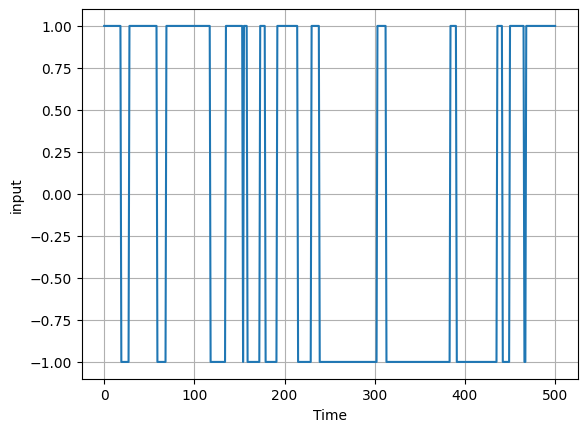

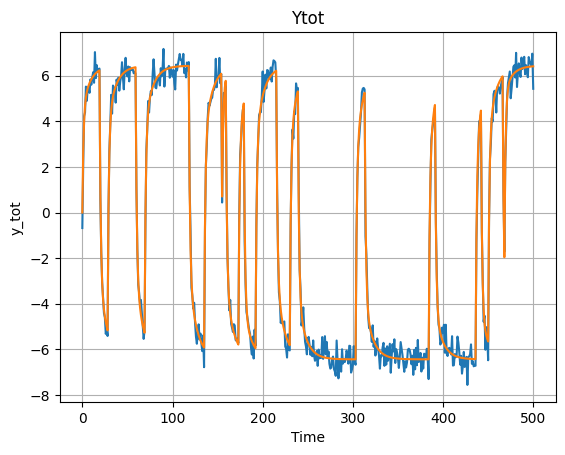

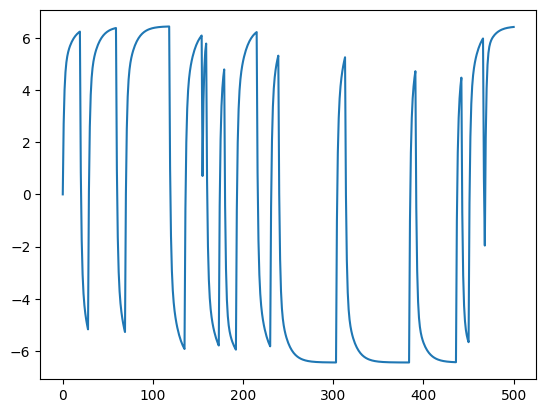

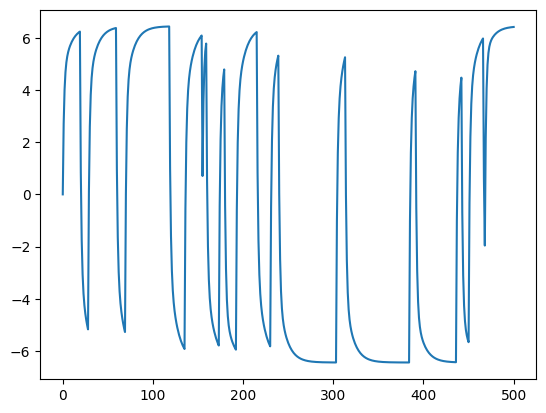

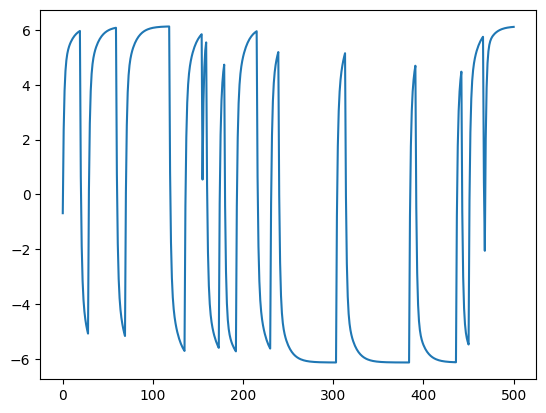

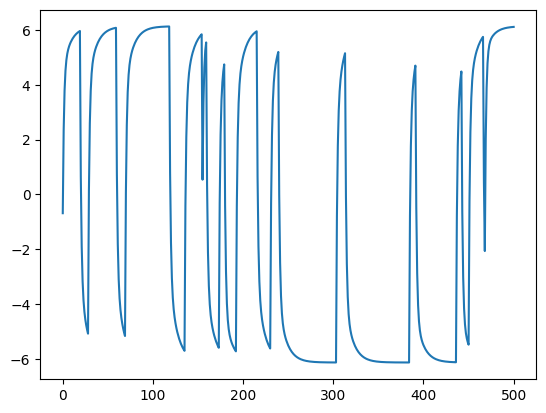

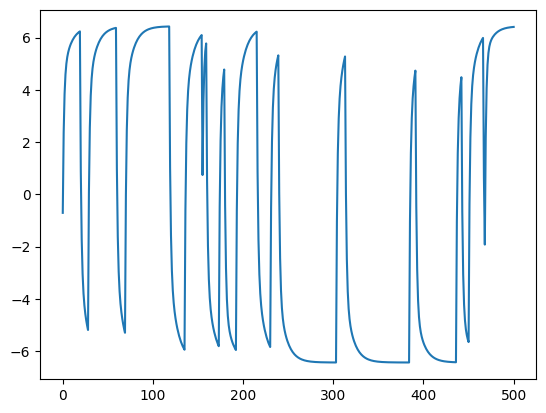

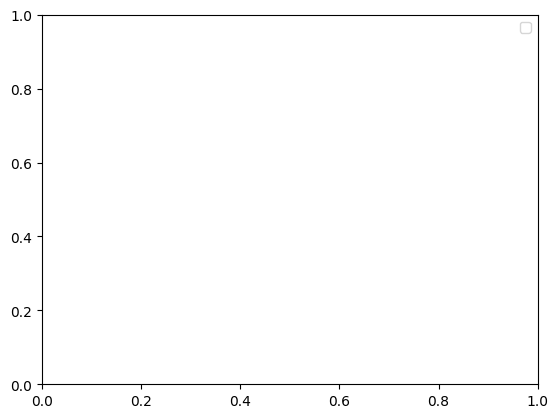

In [36]:
"""Created on Fri Jan 19 2018

@author: Giuseppe Armenise, revised by RBdC

In this test, no error occurs.
Using method='N4SID','MOESP' or 'CVA', if the message
"Kalman filter cannot be calculated" is shown, it means
that the package slycot is not well-installed.

"""

# Checking path to access other files
try:
    from sippy_unipi import system_identification
except ImportError:
    import os
    import sys

    sys.path.append(os.pardir)
    from sippy_unipi import system_identification

import matplotlib.pyplot as plt
import numpy as np

from sippy_unipi import functionset as fset
from sippy_unipi import functionsetSIM as fsetSIM

# Example to test SS-methods

# sample time
ts = 1.0

# SISO SS system (n = 2)
A = np.array([[0.89, 0.0], [0.0, 0.45]])
B = np.array([[0.3], [2.5]])
C = np.array([[0.7, 1.0]])
D = np.array([[0.0]])

tfin = 500
npts = int(tfin / ts) + 1
Time = np.linspace(0, tfin, npts)

# Input sequence
U = np.zeros((1, npts))
[U[0], _, _] = fset.GBN_seq(npts, 0.05)

##Output
x, yout = fsetSIM.SS_lsim_process_form(A, B, C, D, U)

# measurement noise
noise = fset.white_noise_var(npts, [0.15])

# Output with noise
y_tot = yout + noise

#
plt.close("all")
plt.figure(0)
plt.plot(Time, U[0])
plt.ylabel("input")
plt.grid()
plt.xlabel("Time")
#
plt.figure(1)
plt.plot(Time, y_tot[0])
plt.ylabel("y_tot")
plt.grid()
plt.xlabel("Time")
plt.title("Ytot")

##System identification
METHOD = ["N4SID", "CVA", "MOESP", "PARSIM-S", "PARSIM-P", "PARSIM-K"]
lege = ["System"]
for i in range(len(METHOD)):
    method = METHOD[i]
    sys_id = system_identification(y_tot, U, method, SS_fixed_order=2)
    xid, yid = fsetSIM.SS_lsim_process_form(
        sys_id.A, sys_id.B, sys_id.C, sys_id.D, U, sys_id.x0
    )
    #
    plt.plot(Time, yid[0])
    plt.show(block=False)
    lege.append(method)
plt.legend(lege)

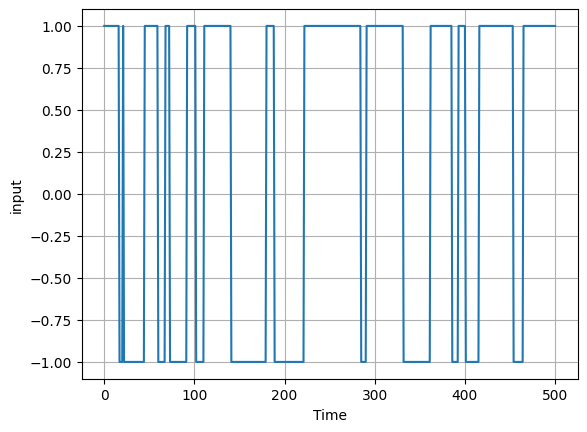

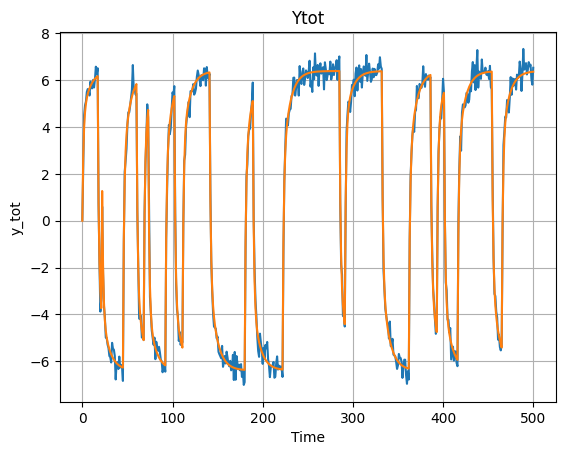

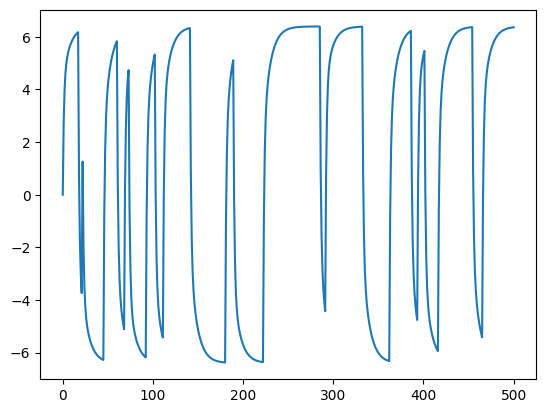

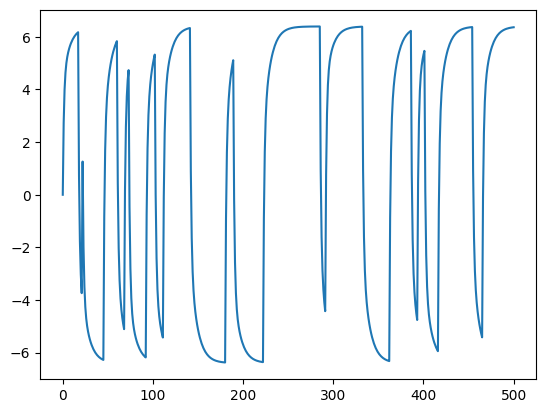

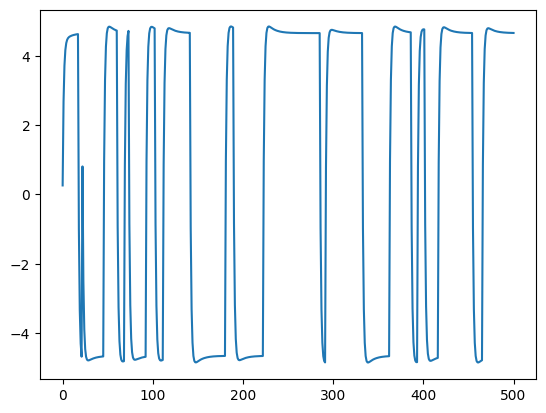

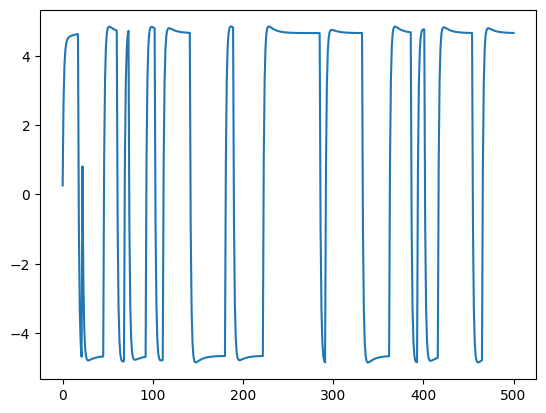

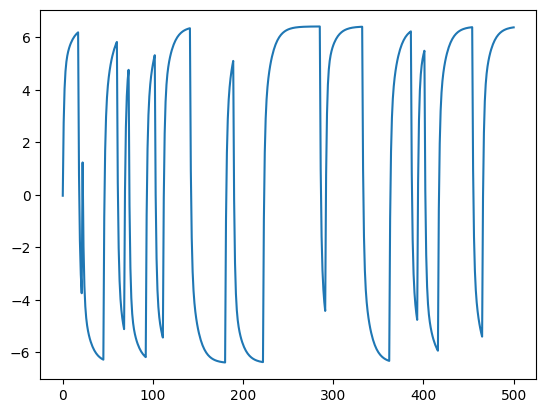

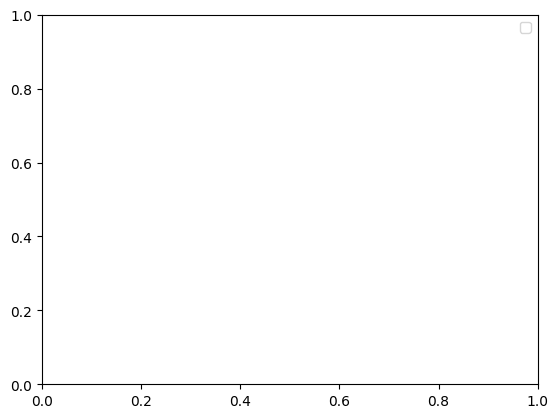

In [1]:
"""Created on Fri Jan 19 2018

@author: Giuseppe Armenise, revised by RBdC

In this test, no error occurs.
Using method='N4SID','MOESP' or 'CVA', if the message
"Kalman filter cannot be calculated" is shown, it means
that the package slycot is not well-installed.

"""

# Checking path to access other files
try:
    from sippy_unipi import system_identification
except ImportError:
    import os
    import sys

    sys.path.append(os.pardir)
    from sippy_unipi import system_identification

import matplotlib.pyplot as plt
import numpy as np

from sippy_unipi import functionset as fset
from sippy_unipi import functionsetSIM as fsetSIM

# Example to test SS-methods

# sample time
ts = 1.0

# SISO SS system (n = 2)
A = np.array([[0.89, 0.0], [0.0, 0.45]])
B = np.array([[0.3], [2.5]])
C = np.array([[0.7, 1.0]])
D = np.array([[0.0]])

tfin = 500
npts = int(tfin / ts) + 1
Time = np.linspace(0, tfin, npts)

# Input sequence
U = np.zeros((1, npts))
[U[0], _, _] = fset.GBN_seq(npts, 0.05)

##Output
x, yout = fsetSIM.SS_lsim_process_form(A, B, C, D, U)

# measurement noise
noise = fset.white_noise_var(npts, [0.15])

# Output with noise
y_tot = yout + noise

#
plt.close("all")
plt.figure(0)
plt.plot(Time, U[0])
plt.ylabel("input")
plt.grid()
plt.xlabel("Time")
#
plt.figure(1)
plt.plot(Time, y_tot[0])
plt.ylabel("y_tot")
plt.grid()
plt.xlabel("Time")
plt.title("Ytot")

##System identification
METHOD = ["N4SID", "CVA", "MOESP", "PARSIM-S", "PARSIM-P", "PARSIM-K"]
lege = ["System"]
for i in range(len(METHOD)):
    method = METHOD[i]
    sys_id = system_identification(y_tot, U, method, SS_fixed_order=2)
    xid, yid = fsetSIM.SS_lsim_process_form(
        sys_id.A, sys_id.B, sys_id.C, sys_id.D, U, sys_id.x0
    )
    #
    plt.plot(Time, yid[0])
    plt.show(block=False)
    lege.append(method)
plt.legend(lege)